# Graph to timeseries generation strategies

We generate timeseries from univariate and multivariate graphs, by walking through the graph and appending values to our sequence.

There are two main components or strategies needed for timeseries generation:

## Selection of next node in graph:

### - StrategySelectNextNodeRandomly:

First strategy and the simplest strategy we can have here is just randomly selecting next node from the pool of all appropriate nodes. (In univariate graphs, every node is appropriate, but in multivariate graph, only appropriate nodes are ones that originate from the univariate graph we are currently on)

### - StrategySelectNextNodeRandomlyFromNeighboursAcrossGraphs and StrategySelectNextNodeRandomlyFromNeighboursFromFirstGraph:

These strategies are very similar to one another. If we have univariate graph it does not matter which one we choose. Each of them will return random neighbour of the last node we analyzed.

If we have a multivariate graph, the strategy from class  StrategySelectNextNodeRandomlyFromNeighboursFromFirstGraph will only walkthrough the first graph, while giving back neighbours of the last node we analyzed from each of the univariate graph in this multivariate one. StrategySelectNextNodeRandomlyFromNeighboursAcrossGraphs strategy on the other hand will continuously switch between univariate graphs and will not just remain on the first one. With this strategy we can also set, how long does the programme spend walking through each graph.

### - StrategySelectNextNodeRandomWithRestart:

This strategy will choose next node randomly, just like StrategySelectNextNodeRandomly, but there will always be 15% chance that it will jump back to the first node of the graph.

### - StrategySelectNextNodeRandomDegree:

This strategy will choose next node randomly from its neighbours based on degree/weight of the connection between the two.

## Selection of next value in the selected node:

Some strategies of graph generation, result in a single node having multiple values instead of just one. If nodes have only one value, you can just select any strategy that isn't specified to be for a certain type of graph.

### - StrategyNextValueInNodeRandom and StrategyNextValueInNodeRandomForSlidingWindow:

These two methods will choose next value from available ones randomly.

### - StrategyNextValueInNodeRoundRobin and StrategyNextValueInNodeRoundRobinForSlidingWindow:

These two methods will choose next value sequentially, in orther of their appearance in original graph. If last one is reached, it will start again at the beginning.

### - StrategyNextValueInNodeOrdinalPartition:

This strategy is designed specifically for the ordinal partition graphs. As their nodes do not store original values, histogram of values is made at the beginning, which is later on used for value selection.

## Additional strategies:

Along with these strategies we can also tell how many values we want to skip, between appending another one. We must also tell how long do we want our timeseries to be.

## Examples:

Here are some examples of graphs and timeseries generated from them:

In [6]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)


from core.model import Timeseries, TimeseriesPreprocessing, TimeseriesPreprocessingSegmentation, TimeseriesPreprocessingSlidingWindow, TimeseriesPreprocessingComposite, TimeseriesView, TimeGraph, ToSequenceVisitorSlidingWindow, ToSequenceVisitor, ToSequenceVisitorOrdinalPartition
from tsg_io.input import CsvFile, TsFile
from from_graph.strategy_to_time_sequence import StrategyNextValueInNodeRandom, StrategyNextValueInNodeRandomForSlidingWindow, StrategyNextValueInNodeRoundRobin, StrategyNextValueInNodeRoundRobinForSlidingWindow, StrategySelectNextNodeRandomlyFromNeighboursAcrossGraphs, StrategySelectNextNodeRandomlyFromNeighboursFromFirstGraph, StrategySelectNextNodeRandomly, StrategySelectNextNodeRandomDegree, StrategySelectNextNodeRandomWithRestart, StrategyNextValueInNodeOrdinalPartition
from to_graph.strategy_linking_graph import StrategyLinkingGraphByValueWithinRange, LinkNodesWithinGraph
from to_graph.strategy_linking_multi_graphs import LinkGraphs
from to_graph.strategy_to_graph import BuildTimeseriesToGraphNaturalVisibilityStrategy, BuildTimeseriesToGraphHorizontalVisibilityStrategy, BuildTimeseriesToGraphOrdinalPartition

amazon_path = os.path.join(os.getcwd(), "amazon", "AMZN.csv")
apple_path = os.path.join(os.getcwd(), "apple", "APPLE.csv")

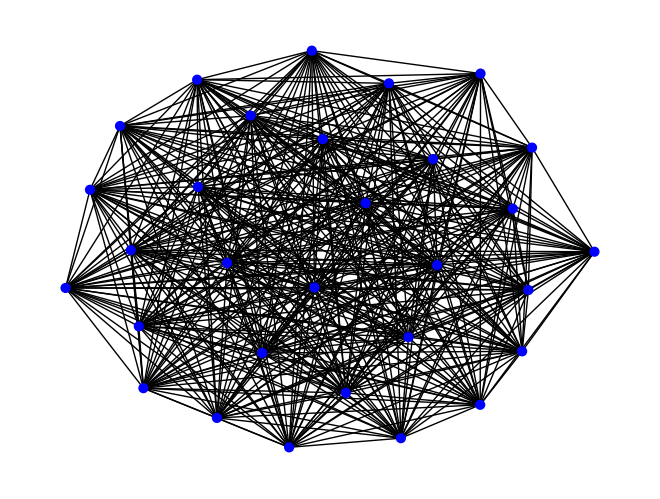

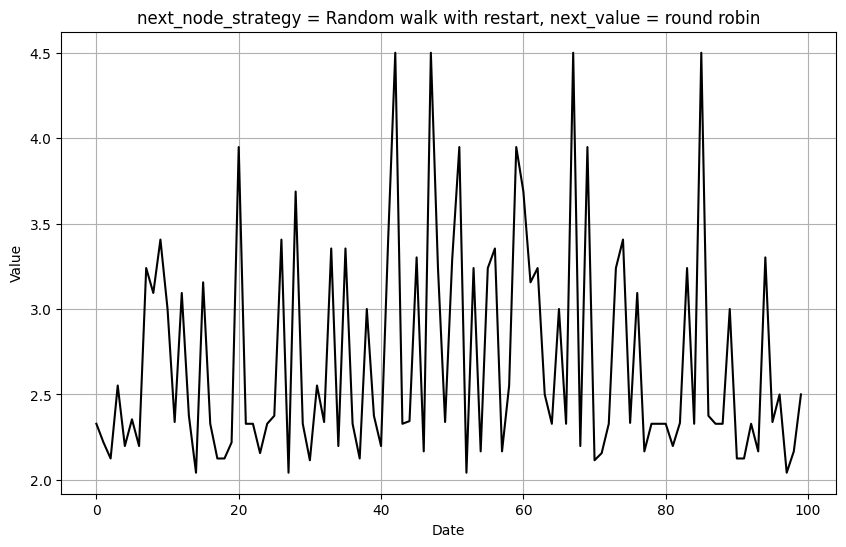

In [7]:
timegraph_1 = Timeseries(CsvFile(amazon_path, "Close").from_csv())\
    .with_preprocessing(TimeseriesPreprocessingSegmentation(60, 90))\
    .to_graph(BuildTimeseriesToGraphNaturalVisibilityStrategy().with_limit(1).get_strategy())\
    .add_edge(0,2)\
    .add_edge(13, 21, weight = 17)\
    .link(LinkNodesWithinGraph().by_value(StrategyLinkingGraphByValueWithinRange(2)).seasonalities(15))\
    .draw("blue")

timegraph_1.to_sequence(ToSequenceVisitor()\
        .next_node_strategy(StrategySelectNextNodeRandomWithRestart())\
        .next_value_strategy(StrategyNextValueInNodeRoundRobin().skip_every_x_steps(1))\
        .ts_length(100))\
    .draw_sequence()

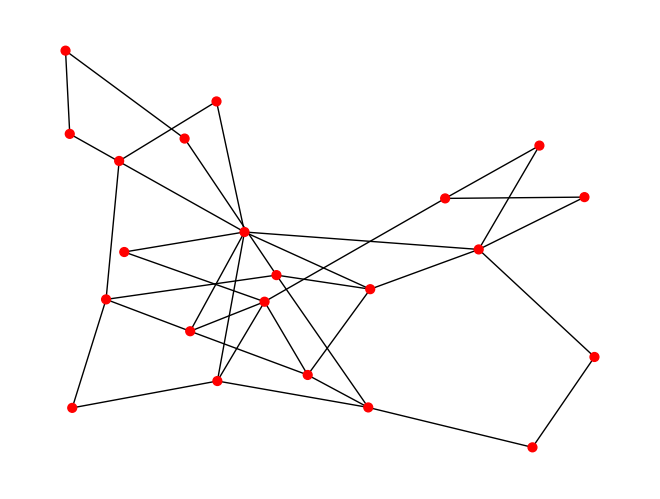

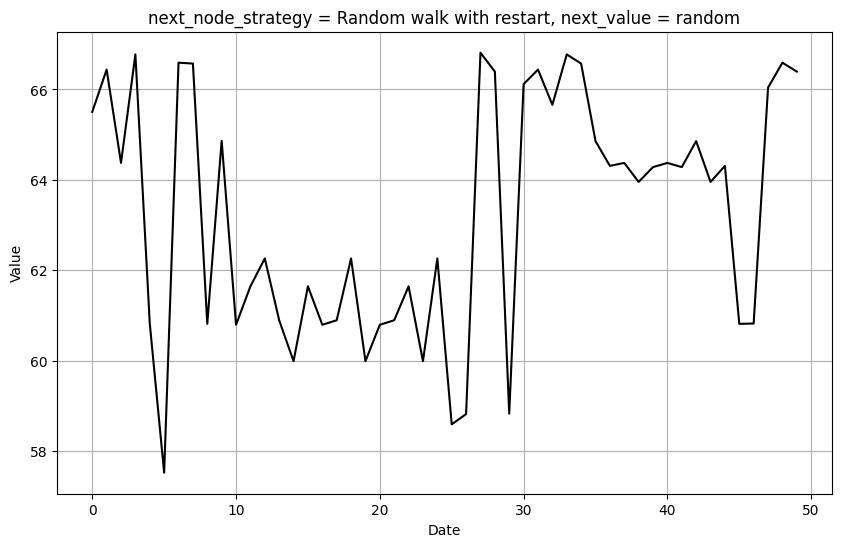

In [8]:
timegraph_2 = Timeseries(CsvFile(apple_path, "Close").from_csv())\
    .with_preprocessing(TimeseriesPreprocessingComposite()\
        .add(TimeseriesPreprocessingSegmentation(60, 120))\
        .add(TimeseriesPreprocessingSlidingWindow(5)))\
    .to_graph(BuildTimeseriesToGraphNaturalVisibilityStrategy().get_strategy())\
    .link(LinkGraphs().sliding_window())\
    .combine_identical_subgraphs()\
    .draw("red")

timegraph_2.to_sequence(ToSequenceVisitorSlidingWindow()\
        .next_node_strategy(StrategySelectNextNodeRandomWithRestart())\
        .next_value_strategy(StrategyNextValueInNodeRandomForSlidingWindow().skip_every_x_steps(1))\
        .ts_length(50))\
    .draw_sequence()

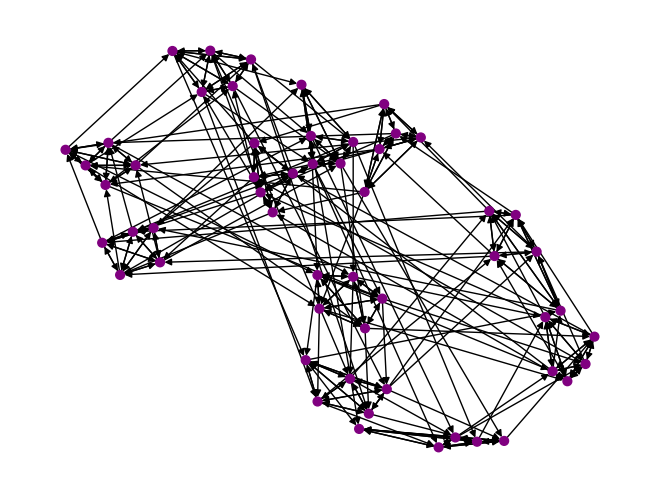

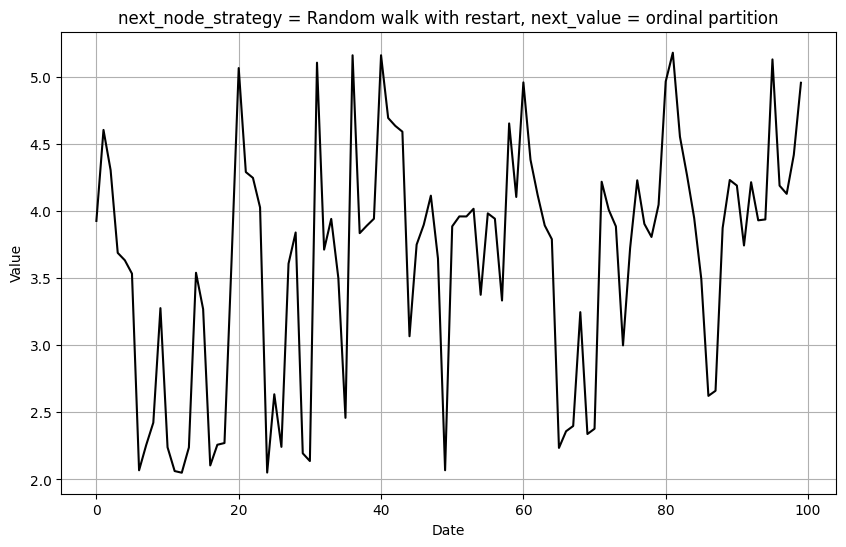

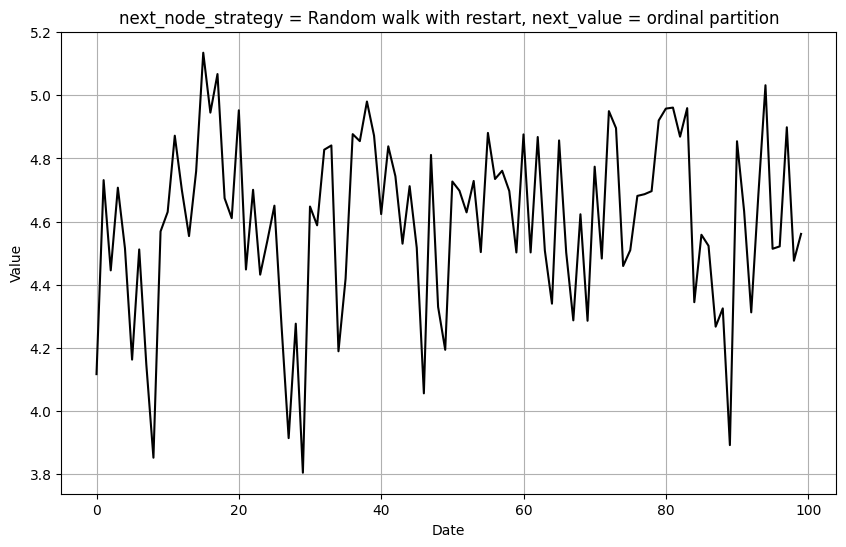

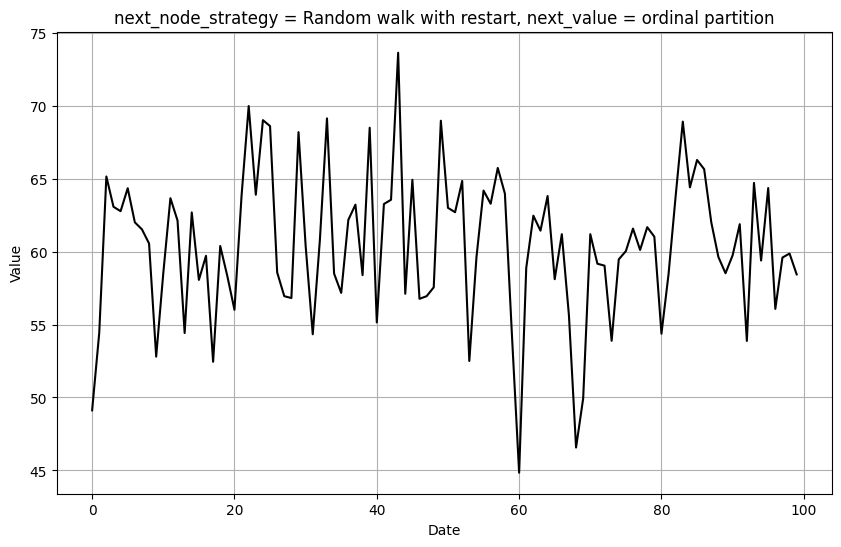

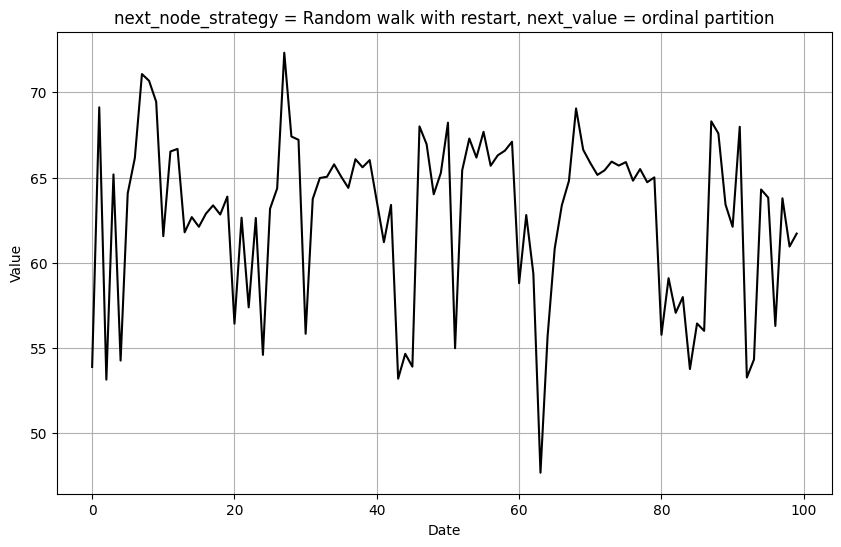

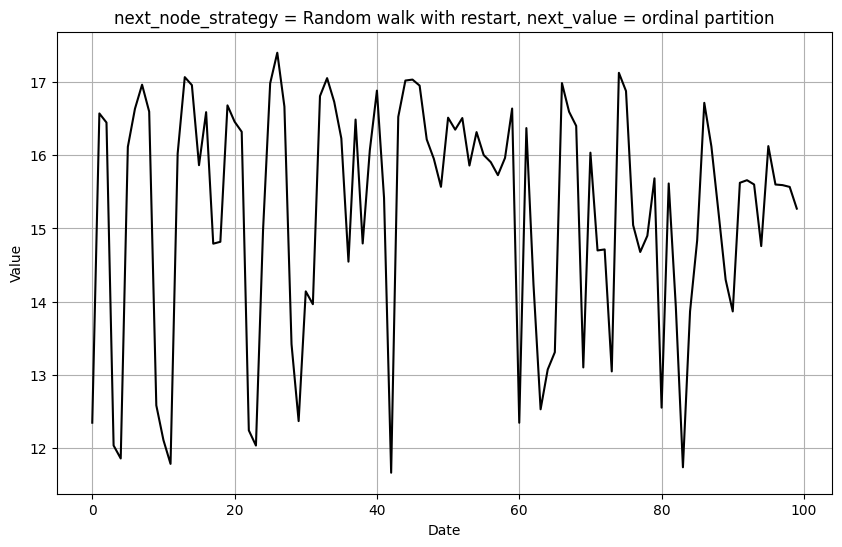

In [9]:
timegraph_3 = Timeseries(CsvFile(amazon_path, "Close").from_csv())\
    .with_preprocessing(TimeseriesPreprocessingSegmentation(60, 120))\
    .add(Timeseries(CsvFile(amazon_path, "Close").from_csv())\
        .with_preprocessing(TimeseriesPreprocessingSegmentation(120, 180)))\
    .add(Timeseries(CsvFile(amazon_path, "Close").from_csv())\
        .with_preprocessing(TimeseriesPreprocessingSegmentation(500, 560)))\
    .add(Timeseries(CsvFile(amazon_path, "Close").from_csv())\
        .with_preprocessing(TimeseriesPreprocessingSegmentation(700, 760)))\
    .add(Timeseries(CsvFile(amazon_path, "Close").from_csv())\
        .with_preprocessing(TimeseriesPreprocessingSegmentation(1000, 1060)))\
    .to_histogram(15)\
    .to_graph(BuildTimeseriesToGraphOrdinalPartition(10, 5).get_strategy())\
    .link(LinkGraphs().time_cooccurrence())\
    .add_edge(0,2)\
    .link(LinkNodesWithinGraph().seasonalities(4))\
    .draw("purple")

timegraph_3.to_sequence(ToSequenceVisitorOrdinalPartition()\
        .next_node_strategy(StrategySelectNextNodeRandomWithRestart())\
        .next_value_strategy(StrategyNextValueInNodeOrdinalPartition())\
        .ts_length(100))\
    .draw_sequence()